# Dynamic Pricing Ride Share

Your goal is to build a dynamic pricing model that incorporates the provided features to predict optimal fares for rides in real-time. The model must consider factors such as demand patterns and supply availability.

In [1]:
import pandas as pd
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Extract the ZIP file
zip_file_path = 'Dynamic Pricing.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('dynamic_pricing_data')

# Load the dataset
csv_file_path = 'dynamic_pricing_data/dynamic_pricing.csv'
data = pd.read_csv(csv_file_path)

# Display the first few rows of the dataset
print(data.head())

   Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium                      90   
1         Evening      Economy                      43   
2       Afternoon      Premium                      76  

In [3]:
# Data Preprocessing
# Define categorical and numerical columns
categorical_cols = ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type']
numerical_cols = ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides', 'Average_Ratings', 'Expected_Ride_Duration']

# Preprocessing for numerical data (scaling)
numerical_transformer = StandardScaler()

# Preprocessing for categorical data (one-hot encoding)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the target variable
X = data.drop('Historical_Cost_of_Ride', axis=1)
y = data['Historical_Cost_of_Ride']

# Add demand and supply related features (example)
X['Demand_Indicator'] = X['Time_of_Booking'].apply(lambda x: 1 if x in ['Evening', 'Night'] else 0)  # High demand at night/evening
X['Driver_Availability'] = X['Number_of_Drivers'] / X['Number_of_Riders']  # Availability ratio

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

RMSE: 75.45429713250864
R2 Score: 0.8386043611184095


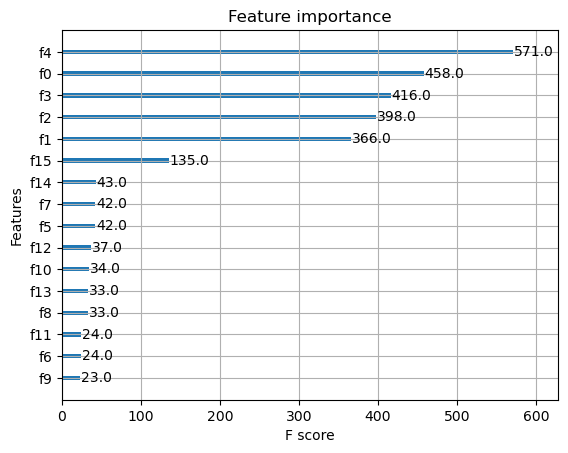

In [4]:
# Model Pipeline
# Define the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

# Optional: Visualize Feature Importance from XGBoost
import matplotlib.pyplot as plt
import xgboost as xgb

# Extract the trained model from the pipeline and get feature importance
model_xgb = pipeline.named_steps['model']
xgb.plot_importance(model_xgb, importance_type='weight')
plt.show()

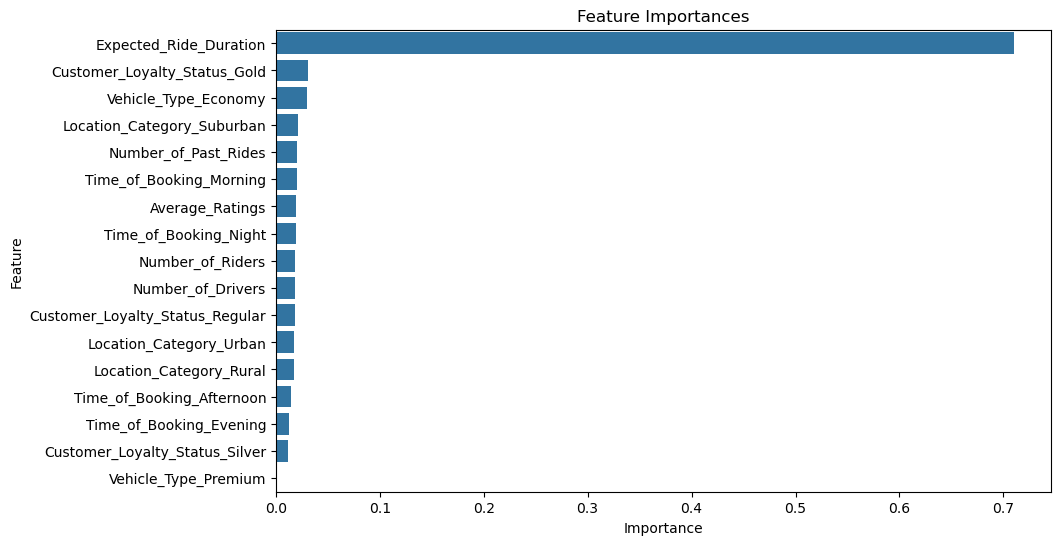

In [5]:
# Feature Importance
# Extract feature importances from the trained model
feature_importances = model.feature_importances_

# Get feature names after one-hot encoding
encoded_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(encoded_feature_names)

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

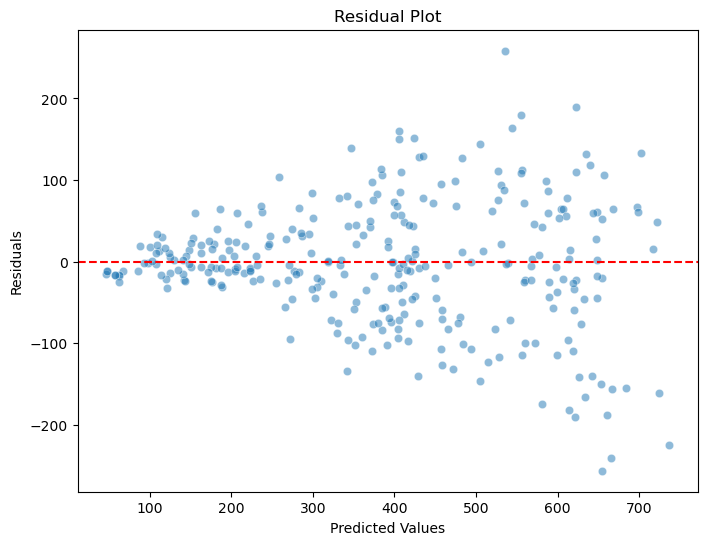

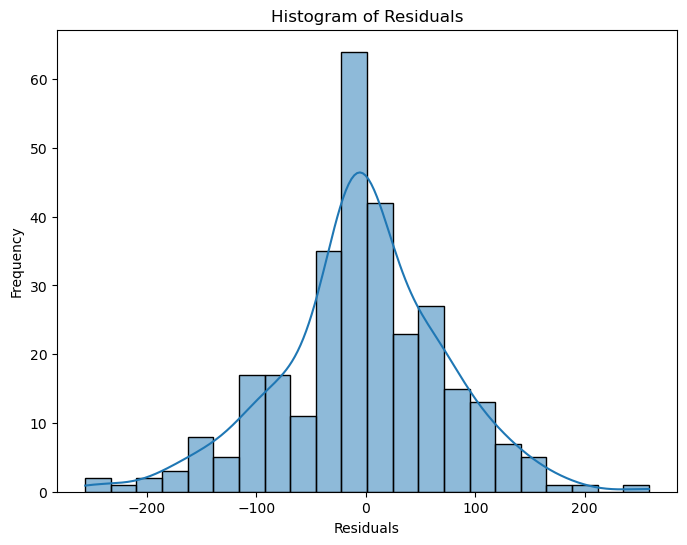

In [6]:
# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Optional: Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Real-Time Prediction Function with Input Validation
def predict_ride_cost(number_of_riders, number_of_drivers, location_category, customer_loyalty_status, 
                      number_of_past_rides, average_ratings, time_of_booking, vehicle_type, expected_ride_duration):
    # Validate inputs
    try:
        # Check if numerical values are positive
        assert number_of_riders >= 0
        assert number_of_drivers >= 0
        assert number_of_past_rides >= 0
        assert average_ratings >= 0 and average_ratings <= 5
        assert expected_ride_duration > 0

        # Check if categorical values are valid
        valid_locations = ['Urban', 'Suburban', 'Rural']
        valid_loyalty_status = ['Silver', 'Regular', 'Gold']
        valid_time_of_booking = ['Morning', 'Afternoon', 'Evening', 'Night']
        valid_vehicle_types = ['Economy', 'Premium']

        assert location_category in valid_locations
        assert customer_loyalty_status in valid_loyalty_status
        assert time_of_booking in valid_time_of_booking
        assert vehicle_type in valid_vehicle_types

    except AssertionError:
        return "Invalid input data. Please check the values provided."

    # Prepare input data
    input_data = pd.DataFrame({
        'Number_of_Riders': [number_of_riders],
        'Number_of_Drivers': [number_of_drivers],
        'Location_Category': [location_category],
        'Customer_Loyalty_Status': [customer_loyalty_status],
        'Number_of_Past_Rides': [number_of_past_rides],
        'Average_Ratings': [average_ratings],
        'Time_of_Booking': [time_of_booking],
        'Vehicle_Type': [vehicle_type],
        'Expected_Ride_Duration': [expected_ride_duration]
    })

    # Predict the cost using the pipeline
    predicted_cost = pipeline.predict(input_data)
    return predicted_cost[0]

# Example usage of the prediction function
predicted_cost = predict_ride_cost(90, 45, 'Urban', 'Silver', 13, 4.47, 'Night', 'Premium', 90)
print(f'Predicted Ride Cost: {predicted_cost}')


Predicted Ride Cost: 327.3302307128906
